In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    confusion_matrix
)

import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

from datasets import Dataset as HFDataset


## Configuration


In [2]:
# ==== File path ====
CSV_PATH = 'fake_notes.csv'  # path to your raw, row-level CSV

# ==== Column names in your CSV ====
ID_COL      = 'patient_id'
# NOTE_COL     = 'patient_note'
NOTE_COL    = 'note_len_filtered'
TIME_COL    = 'timestamp'
SEX_COL     = 'sex'
ETHN_COL    = 'ethnicity'
ANXIETY_COL = 'anxiety'

# ==== Algorithm ====
ALGO = 'BigBird'  # 'LR' or 'BigBird'

# ==== BigBird hyperparameters ====
MODEL_NAME    = 'yikuan8/Clinical-BigBird'
MAX_LEN       = 512   # placeholder; will be set from 75th percentile of length distribution
EPOCHS        = 3
BATCH_SIZE    = 2
LEARNING_RATE = 2e-5
WEIGHT_DECAY  = 0.0
SEED          = 42

TEST_SIZE = 0.2          # fraction for test split (stratified by patient-level label)

OUT_DIR = 'results_notebook'
os.makedirs(OUT_DIR, exist_ok=True)


In [3]:
def map_yes_no(series):
    # Map yes/no-like strings to 1/0
    s = series.astype(str).str.strip().str.lower()
    yes_vals = {'yes','y','true','1','t'}
    no_vals  = {'no','n','false','0','f'}
    out = pd.Series(index=series.index, dtype='float')
    out[s.isin(yes_vals)] = 1
    out[s.isin(no_vals)]  = 0
    # leave others as NaN
    return out

def compute_binary_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'fpr': fpr,
    }

def aggregate_by_patient(
    df,
    id_col: str,
    note_col: str,
    time_col: str,
    sex_col: str,
    ethn_col: str,
    anxiety_col: str,
) -> pd.DataFrame:
    """
    Aggregate row-level notes to patient-level:
    - Sort notes per patient from latest to earliest.
    - Concatenate all notes into a single string.
    - Label = 1 if any anxiety='yes' within the patient, else 0.
    - Sex and ethnicity are taken as the mode per patient.
    """

    # Sort by patient and time: id ascending, time descending (latest first)
    df_sorted = df.sort_values(
        by=[id_col, time_col],
        ascending=[True, False],
        kind='mergesort',
    ).copy()

    # Normalize note col to string
    df_sorted[note_col] = df_sorted[note_col].astype(str).fillna('')

    # Map anxiety to 0/1
    anx_num = map_yes_no(df_sorted[anxiety_col])
    df_sorted['_anxiety_bin'] = anx_num

    def _agg(group: pd.DataFrame) -> pd.Series:
        # Notes already sorted latest→earliest from global sort
        notes_concat = ' '.join(group[note_col].tolist())

        # Label: any YES within patient → 1
        label = int((group['_anxiety_bin'] == 1).any())

        def mode_or_first(col_name: str):
            vals = group[col_name].dropna()
            if len(vals) == 0:
                return np.nan
            try:
                return vals.mode(dropna=True).iloc[0]
            except Exception:
                return vals.iloc[0]

        sex = mode_or_first(sex_col)
        ethn = mode_or_first(ethn_col)

        return pd.Series(
            {
                'note_agg': notes_concat,
                'label': label,
                'sex': sex,
                'ethnicity': ethn,
            }
        )

    agg_df = df_sorted.groupby(id_col, as_index=False).apply(_agg).reset_index(drop=True)
    return agg_df

def evaluate_by_demo(test_df, y_pred, label_col: str = 'label', demo_cols=None) -> pd.DataFrame:
    if demo_cols is None:
        demo_cols = []
    rows = []
    for dcol in demo_cols:
        vals = test_df[dcol].dropna().unique().tolist()
        for v in sorted(map(str, vals)):
            mask = test_df[dcol].astype(str) == v
            y_true_g = test_df.loc[mask, label_col].values
            y_pred_g = np.array(y_pred)[mask.values]
            if len(y_true_g) == 0:
                continue
            m = compute_binary_metrics(y_true_g, y_pred_g)
            m.update({'demo_col': dcol, 'group': v, 'n': int(len(y_true_g))})
            rows.append(m)
    return pd.DataFrame(rows)


## Load raw data and aggregate to patient-level


In [4]:
# Load CSV
df_raw = pd.read_csv(CSV_PATH)

# Basic sanity checks on required columns
for col in [NOTE_COL, ID_COL, TIME_COL, SEX_COL, ETHN_COL, ANXIETY_COL]:
    assert col in df_raw.columns, f'Missing required column: {col}'

# Aggregate notes to patient-level (notes sorted from most recent to oldest)
df_pat = aggregate_by_patient(
    df_raw,
    id_col=ID_COL,
    note_col=NOTE_COL,
    time_col=TIME_COL,
    sex_col=SEX_COL,
    ethn_col=ETHN_COL,
    anxiety_col=ANXIETY_COL,
)
print('Patients:', len(df_pat))
print('Label distribution:', df_pat['label'].value_counts().to_dict())

# Analyse token length distribution after merging
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

token_lengths = df_pat['note_agg'].astype(str).apply(
    lambda text: len(tokenizer(text, truncation=False, add_special_tokens=True)['input_ids'])
)

print('=== Token length summary (after merging notes per patient) ===')
print(token_lengths.describe(percentiles=[0.5, 0.75, 0.9, 0.95]))

# Set MAX_LEN to 75th percentile
MAX_LEN = int(token_lengths.quantile(0.75))
print(f'Setting MAX_LEN to 75th percentile: {MAX_LEN}')

# Demographic columns (fixed, no presence-checking)
DEMO_COLS = ['sex', 'ethnicity']

# Stratified train/test split at patient-level
train_df, test_df = train_test_split(
    df_pat,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=df_pat['label'],
)
print('Train patients:', len(train_df), ' Test patients:', len(test_df))


/tmp/ipython-input-3774787805.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_df = df_sorted.groupby(id_col, as_index=False).apply(_agg).reset_index(drop=True)


Patients: 1000
Label distribution: {1: 529, 0: 471}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

=== Token length summary (after merging notes per patient) ===
count    1000.000000
mean     1288.447000
std       217.689283
min       802.000000
50%      1285.500000
75%      1458.000000
90%      1582.300000
95%      1631.100000
max      1845.000000
Name: note_agg, dtype: float64
Setting MAX_LEN to 75th percentile: 1458
Train patients: 800  Test patients: 200


In [5]:
train_df, test_df = train_test_split(df_pat, test_size=TEST_SIZE, random_state=SEED, stratify=df_pat['label'])
print('Train patients:', len(train_df), 'Test patients:', len(test_df))
print('Train label counts:', train_df['label'].value_counts().to_dict())
print('Test  label counts:', test_df['label'].value_counts().to_dict())


Train patients: 800 Test patients: 200
Train label counts: {1: 423, 0: 377}
Test  label counts: {1: 106, 0: 94}


## Train & Predict — Logistic Regression (TF–IDF)
Set `ALGO = 'LR'` in the configuration cell.


In [6]:
def run_lr(train_df, test_df, text_col, label_col):
    count_vect = CountVectorizer()
    tfidf = TfidfTransformer()

    X_train_counts = count_vect.fit_transform(train_df[text_col])
    X_train_tfidf  = tfidf.fit_transform(X_train_counts)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_tfidf, train_df[label_col])

    X_test_counts = count_vect.transform(test_df[text_col])
    X_test_tfidf  = tfidf.transform(X_test_counts)

    y_pred = clf.predict(X_test_tfidf)
    return y_pred

# Run LR baseline if selected
y_pred_lr = None
if ALGO == 'LR':
    y_pred_lr = run_lr(train_df, test_df, text_col='note_agg', label_col='label')
    print('Logistic Regression prediction complete.')


## Train & Predict — Clinical BigBird
Set `ALGO = 'BigBird'`.

In [8]:
def run_bigbird(
    train_df,
    test_df,
    text_col,
    label_col,
    model_name=MODEL_NAME,
    max_len=MAX_LEN,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    seed=SEED,
):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    hf_train = HFDataset.from_pandas(train_df[[text_col, label_col]])
    hf_test = HFDataset.from_pandas(test_df[[text_col, label_col]])

    def tokenize_function(examples):
        return tokenizer(
            examples[text_col],
            padding='max_length',
            truncation=True,
            max_length=max_len,
        )

    tokenized_train = hf_train.map(tokenize_function, batched=True, remove_columns=[text_col])
    tokenized_test = hf_test.map(tokenize_function, batched=True, remove_columns=[text_col])

    tokenized_train = tokenized_train.rename_column(label_col, 'labels')
    tokenized_test = tokenized_test.rename_column(label_col, 'labels')

    tokenized_train.set_format('torch')
    tokenized_test.set_format('torch')

    def _compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        m = compute_binary_metrics(labels, preds)
        return {
            'accuracy': m['accuracy'],
            'precision': m['precision'],
            'recall': m['recall'],
            'f1': m['f1'],
        }

    training_args = TrainingArguments(
        output_dir='./bb_runs_nb',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=lr,
        weight_decay=weight_decay,
        eval_strategy='epoch',
        save_strategy='no',
        seed=seed,
        logging_steps=0,
        logging_strategy='no', # Added to resolve ValueError: logging strategy IntervalStrategy.STEPS requires non-zero --logging_steps
        report_to='none',      # disable W&B / TensorBoard / etc.
        disable_tqdm=True,     # no progress bars
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        compute_metrics=_compute_metrics,
    )

    trainer.train()
    preds = trainer.predict(tokenized_test)
    y_pred = np.argmax(preds.predictions, axis=1)
    return y_pred

y_pred_bb = None
if ALGO == 'BigBird':
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    y_pred_bb = run_bigbird(train_df, test_df, text_col='note_agg', label_col='label')
    print('BigBird prediction complete.')

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at yikuan8/Clinical-BigBird and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/tmp/ipython-input-643077177.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Input ids are automatically padded from 1458 to 1472 to be a multiple of `config.block_size`: 64


{'eval_loss': 0.6915978789329529, 'eval_accuracy': 0.53, 'eval_precision': 0.53, 'eval_recall': 1.0, 'eval_f1': 0.6928104575163399, 'eval_runtime': 8.7911, 'eval_samples_per_second': 22.75, 'eval_steps_per_second': 11.375, 'epoch': 1.0}
{'eval_loss': 0.6930361986160278, 'eval_accuracy': 0.53, 'eval_precision': 0.53, 'eval_recall': 1.0, 'eval_f1': 0.6928104575163399, 'eval_runtime': 8.7457, 'eval_samples_per_second': 22.868, 'eval_steps_per_second': 11.434, 'epoch': 2.0}
{'eval_loss': 0.6871967911720276, 'eval_accuracy': 0.515, 'eval_precision': 0.5348837209302325, 'eval_recall': 0.6509433962264151, 'eval_f1': 0.5872340425531914, 'eval_runtime': 8.731, 'eval_samples_per_second': 22.907, 'eval_steps_per_second': 11.453, 'epoch': 3.0}
{'train_runtime': 339.4578, 'train_samples_per_second': 7.07, 'train_steps_per_second': 3.535, 'train_loss': 0.6933646647135416, 'epoch': 3.0}
BigBird prediction complete.


## Evaluate (overall & per-demographic-group) and save CSVs


In [9]:
# Pick predictions based on ALGO
if ALGO == 'LR':
    y_pred = y_pred_lr
elif ALGO == 'BigBird':
    y_pred = y_pred_bb
else:
    raise ValueError(f'Unknown ALGO: {ALGO}')

# Overall metrics
metrics_overall = compute_binary_metrics(test_df['label'].values, y_pred)
print('=== Overall test metrics ===')
for k, v in metrics_overall.items():
    if k in ['tn', 'fp', 'fn', 'tp']:
        continue
    print(f'{k}: {v:.3f}')
print('Confusion matrix (tn, fp, fn, tp):', metrics_overall['tn'], metrics_overall['fp'], metrics_overall['fn'], metrics_overall['tp'])

# Per-group metrics for demographic columns
per_group = evaluate_by_demo(test_df, y_pred, label_col='label', demo_cols=DEMO_COLS)
print('\n=== Per-group metrics by demographic ===')
try:
    display(per_group)
except NameError:
    print(per_group)


=== Overall test metrics ===
accuracy: 0.515
precision: 0.535
recall: 0.651
f1: 0.587
fpr: 0.638
Confusion matrix (tn, fp, fn, tp): 34 60 37 69

=== Per-group metrics by demographic ===


,accuracy,precision,recall,f1,tn,fp,fn,tp,fpr,demo_col,group,n
0,0.627119,0.627119,1.000000,0.770833,0,22,0,37,1.000000,sex,Female,59
1,0.440000,0.388889,0.411765,0.400000,19,22,20,14,0.536585,sex,Male,75
2,0.500000,0.529412,0.514286,0.521739,15,16,17,18,0.516129,sex,Other,66
3,0.416667,0.500000,0.428571,0.461538,2,3,4,3,0.600000,ethnicity,Asian,12
4,0.400000,0.416667,0.714286,0.526316,1,7,2,5,0.875000,ethnicity,Black,15
5,0.437500,0.454545,0.625000,0.526316,2,6,3,5,0.750000,ethnicity,Latino,16
6,0.545455,0.500000,0.200000,0.285714,5,1,4,1,0.166667,ethnicity,Mixed,11
7,0.692308,0.750000,0.750000,0.750000,3,2,2,6,0.400000,ethnicity,Unknown,13
8,0.533333,0.636364,0.700000,0.666667,1,4,3,7,0.800000,ethnicity,White,15


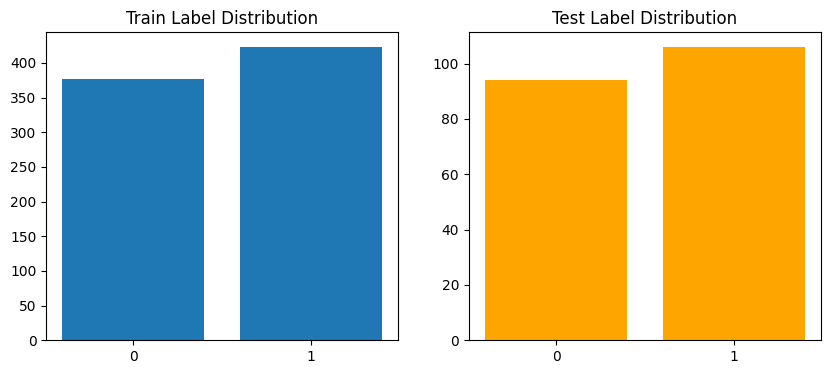

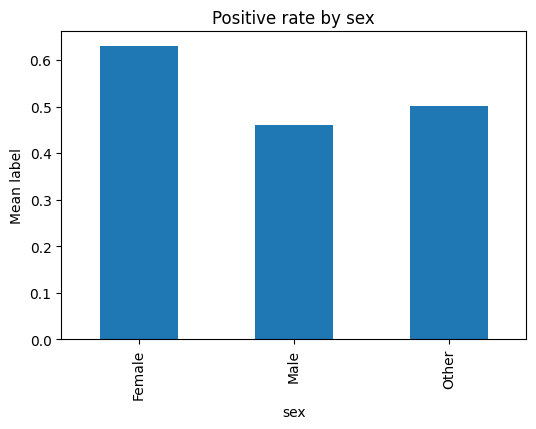

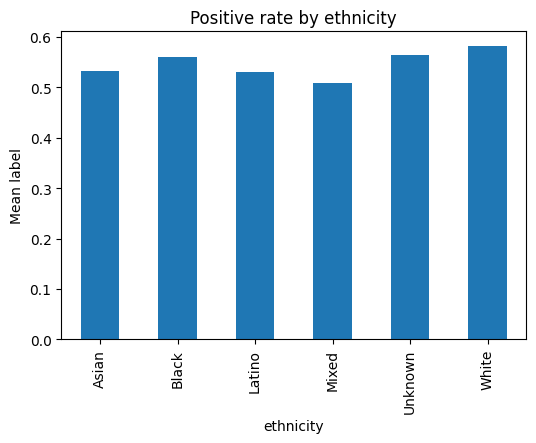

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(train_df['label'], bins=[-0.5, 0.5, 1.5], rwidth=0.8)
ax[0].set_title('Train Label Distribution')
ax[0].set_xticks([0, 1])

ax[1].hist(test_df['label'], bins=[-0.5, 0.5, 1.5], rwidth=0.8, color='orange')
ax[1].set_title('Test Label Distribution')
ax[1].set_xticks([0, 1])

plt.show()

for dcol in DEMO_COLS:
    plt.figure(figsize=(6, 4))
    df_pat.groupby(dcol)['label'].mean().plot(kind='bar')
    plt.title('Positive rate by ' + dcol)
    plt.ylabel('Mean label')
    plt.show()
